In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from upsetplot import UpSet
import mygene
import matplotlib.font_manager as fm
# Path to the Arial Sans font file
font_path = '/home/qcw1/fonts/arial.ttf'
# Add the font to Matplotlib's font manager
fm.fontManager.addfont(font_path)
# Set DejaVu Sans as the default font
plt.rcParams['font.family'] = 'arial'

import matplotlib.style as style
style.core.USER_LIBRARY_PATHS.append("/n/groups/klein/qiu/matplotlib_styles")

qw_light = '/n/groups/klein/qiu/matplotlib_styles/qw_light_paper.mplstyle'
plt.style.use(qw_light)

figure_path = '/n/groups/klein/qiu/exp_0070_analysis/220718_Thorough_Analysis/240315_Paper_Writing/raw_figures/'


In [2]:
# Function to create an UpSet plot for any models
def plot_upset_diagram(models_to_compare):
    """
    Creates an UpSet plot showing the overlap of significant genes (p < 0.05) for selected models.

    Parameters:
    models_to_compare (list): List of model keys to compare (from 'model_labels').

    Returns:
    None: Displays the UpSet plot.
    """
    # Convert model names to respective labels
    converted_labels = [model_labels[model] for model in models_to_compare]

    # Get significant genes (p < 0.05) for each model
    significant_genes = {
        converted_labels[i]: set(filtered_df[filtered_df[models_to_compare[i]] < 0.01]['Gene'])
        for i in range(len(models_to_compare))
    }

    # Create a binary membership dataframe
    all_genes = set().union(*significant_genes.values())
    gene_membership = pd.DataFrame({model: [gene in sig_genes for gene in all_genes]
                                    for model, sig_genes in significant_genes.items()},
                                   index=all_genes)

    # Convert DataFrame rows to tuple index and count occurrences
    upset_data_tuples = gene_membership.astype(bool).groupby(list(gene_membership.columns)).size()

    # # Filter out intersections with zero counts
    # upset_data_tuples = upset_data_tuples[upset_data_tuples >= 0]

    # Print the filtered upset data tuples for debugging


    # Plot the UpSet diagram, excluding empty subsets explicitly
    UpSet(upset_data_tuples, subset_size='auto',
          #sort_by='cardinality',
          include_empty_subsets=False,show_counts='%d').plot()

    plt.title(f'Overlap of Significant Genes for {", ".join(converted_labels)}')
    #plt.show()
    plt.savefig(figure_path + f'Upset_plot_{cellstate}_overlap_of_{"_".join(converted_labels)}.pdf',
                 bbox_inches='tight',dpi=100)


## Cycle through cell states to get information

/tmp/ipykernel_27458/76456522.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'Significant_In_Any_Model'] = significant_genes.any(axis=1)
/tmp/ipykernel_27458/76456522.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'Significance_Type'] = ['Shared' if row.sum() > 1 else 'Unique' if row.sum() == 1 else None for row in significant_genes.values]
/tmp/ipykernel_27458/76456522.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

     Gene  Intercept_coef  Intercept_pval  Organ_SP_coef  Organ_SP_pval  \
0   Creb1        3.052070   3.384187e-102       0.535119       0.007438   
1  Mfsd7b        1.277831    8.425724e-26      -0.199187       0.244279   
2    Dph6        3.174992   1.094055e-105      -0.191570       0.348759   
3   Lamp2        2.404369    5.521892e-62       0.694666       0.000640   
4   Rnf38        1.726728    1.275102e-34       0.366249       0.064117   

   IL17_coef  IL17_pval  Organ_SP:IL17_coef  Organ_SP:IL17_pval  EPO_coef  \
0   0.544102   0.010589           -0.684555            0.015670 -0.018765   
1  -0.321410   0.077639            0.778147            0.001326 -0.332608   
2   0.077011   0.723516            0.185232            0.522558 -0.159728   
3   0.494431   0.022482           -1.034060            0.000335 -0.263533   
4   0.121790   0.563130            0.100662            0.719510 -0.055946   

   ...  model_4_lrt_pval_corrected  model_5_lrt_pval_corrected  \
0  ...              

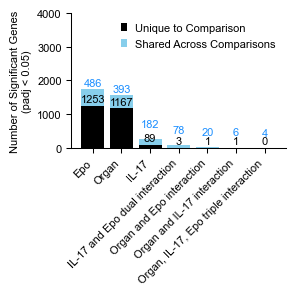

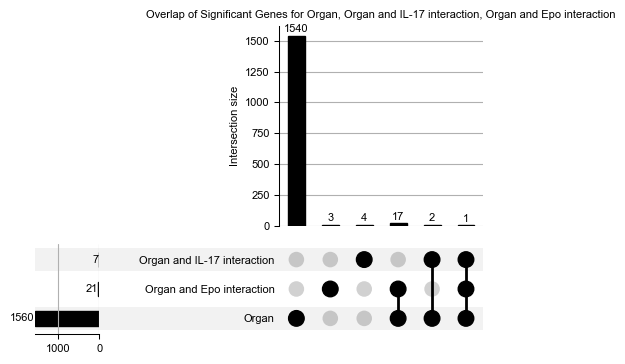

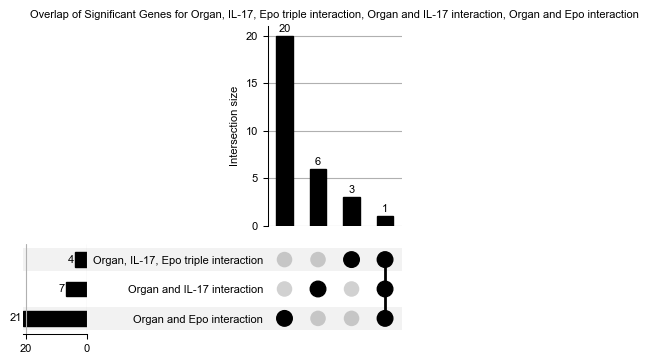

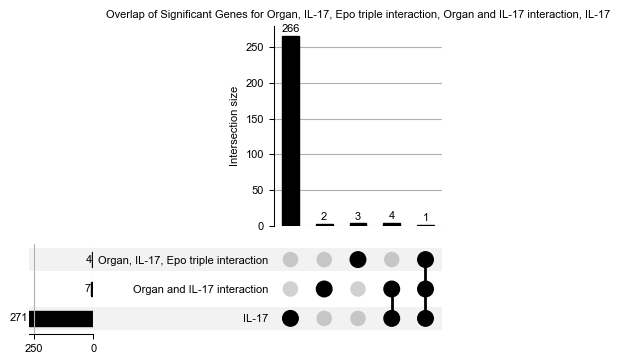

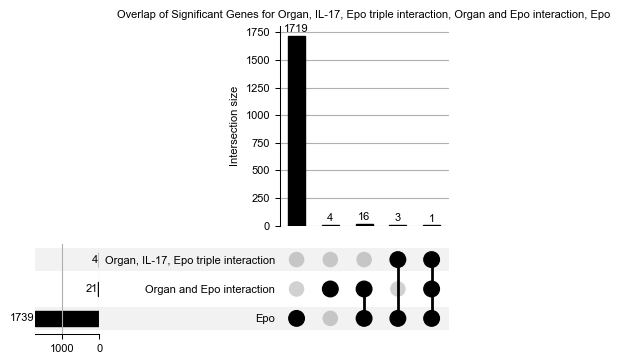

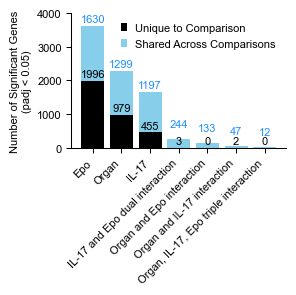

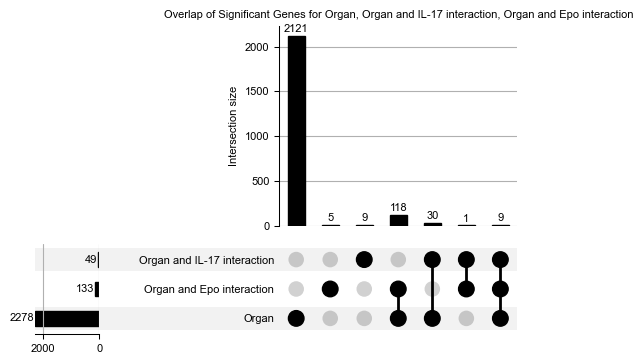

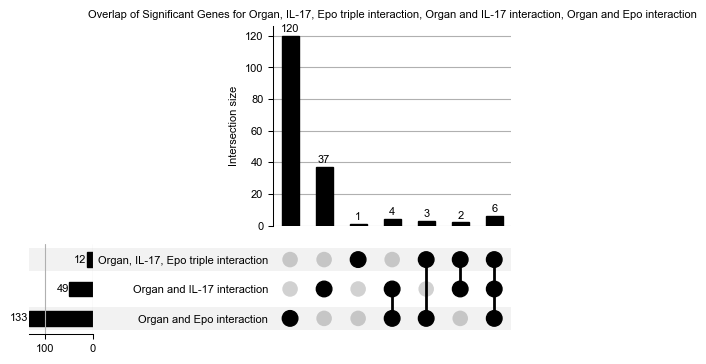

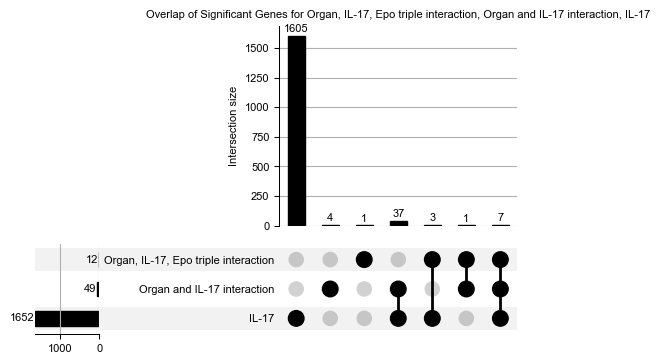

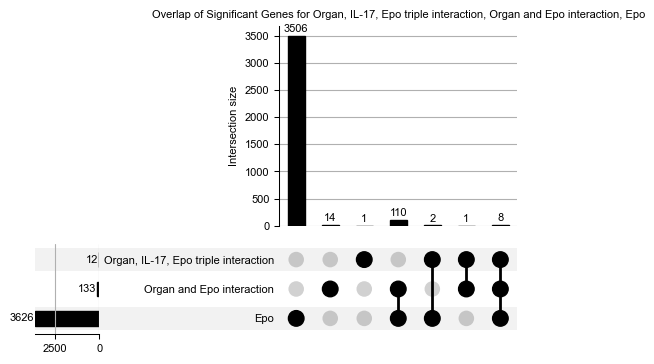

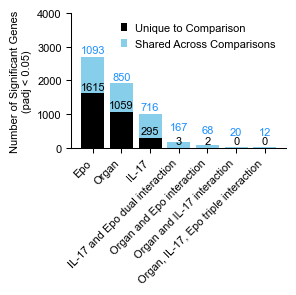

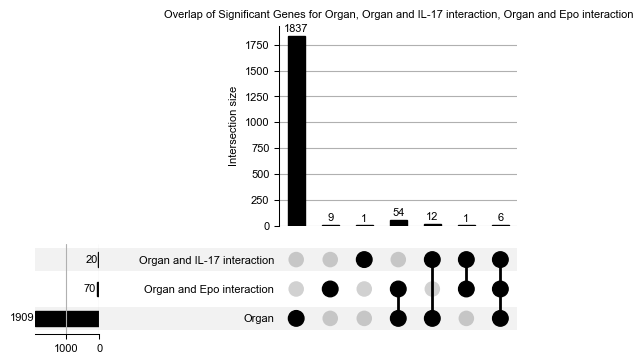

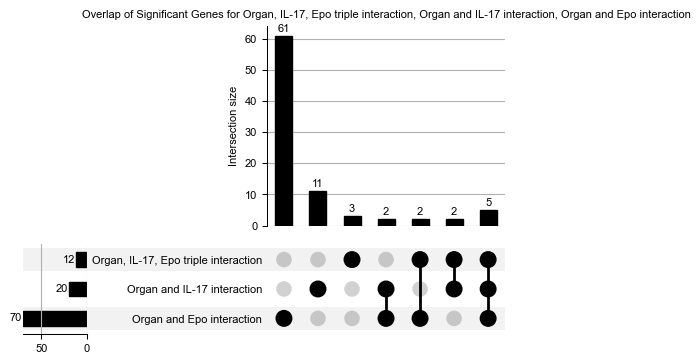

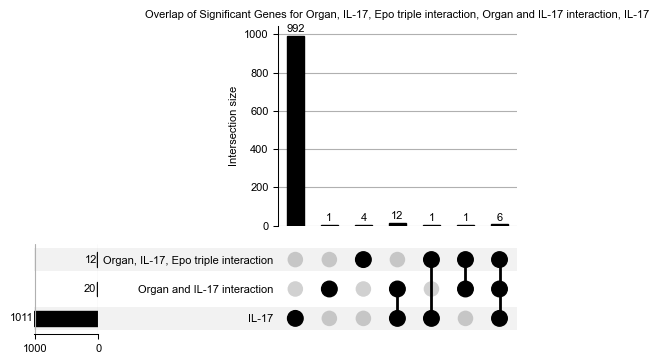

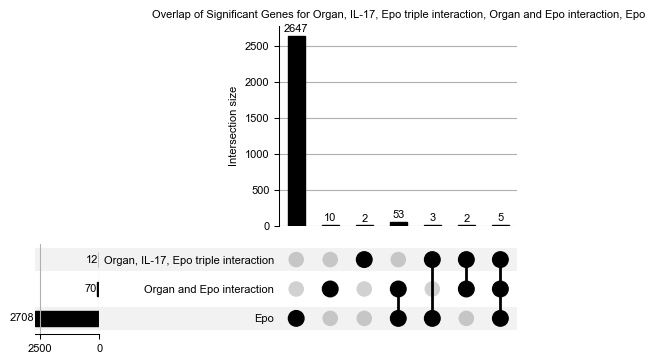

In [9]:
# Initialize mygene object
mg = mygene.MyGeneInfo()

# Initialize an empty list to store DataFrames for each cellstate
significant_genes_combined = []


for cellstate in ['EEP','CEP-1','CEP-2']:
    # Load the dataset
    file_path = f'241002_GLM_Updated_results_{cellstate}.csv'
    df = pd.read_csv(file_path, index_col=0)

    # Filter out genes that start with 'Gm', 'mt', 'Rps', or 'Rpl'
    filtered_df = df[(~df['Gene'].str.startswith(('Gm', 'mt', 'Rps', 'Rpl'))) &
                     (~df['Gene'].str.endswith('Rik'))
                    ]

    # Define the models for which we want to count significant genes
    models = [
        'model_0_lrt_pval_corrected',
        'model_1_lrt_pval_corrected',
        'model_2_lrt_pval_corrected',
        'model_3_lrt_pval_corrected',
        'model_4_lrt_pval_corrected',
        'model_5_lrt_pval_corrected',
        'model_6_lrt_pval_corrected'
    ]

    # Identify genes that are significant (p < 0.01) for each model
    significant_genes = filtered_df.loc[:,models] < 0.01

    # Create a dictionary to map model names to their corresponding comparisons
    model_labels = {
        'model_0_lrt_pval_corrected': 'Organ',
        'model_1_lrt_pval_corrected': 'Organ and IL-17 interaction',
        'model_2_lrt_pval_corrected': 'Epo',
        'model_3_lrt_pval_corrected': 'IL-17',
        'model_4_lrt_pval_corrected': 'IL-17 and Epo dual interaction',
        'model_5_lrt_pval_corrected': 'Organ, IL-17, Epo triple interaction',
        'model_6_lrt_pval_corrected': 'Organ and Epo interaction'
    }
    
    # Map the model column names to their labels
    significant_genes.columns = significant_genes.columns.map(model_labels)

    ### MODIFY ORIGINAL DATAFRAME
    # 1. Boolean column for significance in at least one model
    filtered_df.loc[:,'Significant_In_Any_Model'] = significant_genes.any(axis=1)

    # 2. Categorical column for shared or unique
    filtered_df.loc[:,'Significance_Type'] = ['Shared' if row.sum() > 1 else 'Unique' if row.sum() == 1 else None for row in significant_genes.values]

    # 3. Column with model labels where significant
    filtered_df.loc[:,'Significant_In_Models'] = significant_genes.apply(lambda row: ', '.join(row.index[row].tolist()) if row.any() else None, axis=1)

    # 4. Add a column for the number of models where the gene is significant
    filtered_df.loc[:,'Number_of_Models_Significant'] = significant_genes.sum(axis=1)
    # Save the modified DataFrame to a CSV file
    filtered_df.to_csv(f'modified_significant_genes_{cellstate}.csv')
    
    
    ### SAVE A SUBSET DATA FRAME WHICH HAS THE GENES FROM IL17 and ORGAN INTERACTION
     # Filter for genes significant in 'Organ and IL-17 interaction' or 'Organ, IL-17, Epo triple interaction'
    selected_models = ['Organ and IL-17 interaction', 'Organ, IL-17, Epo triple interaction']
    significant_subset = significant_genes[selected_models].any(axis=1)

    # Subset the filtered DataFrame to get the genes that are significant in either of the selected models
    subset_df = filtered_df[significant_subset].copy()

    # Add a column for the cellstate
    subset_df['Cellstate'] = cellstate

    # Append the DataFrame to the list
    significant_genes_combined.append(subset_df)
    
    ### PLOT THE GLM OVERLAPPING GENES
    
    # Identify unique and shared significant genes
    unique_significant_counts = {}
    shared_significant_counts = {}

    for model in significant_genes.columns:
        # Genes that are significant in only this model
        unique_significant = significant_genes[model] & ~(significant_genes.drop(columns=[model]).any(axis=1))
        unique_significant_counts[model] = unique_significant.sum()

        # Genes that are significant in this and at least one other model
        shared_significant = significant_genes[model] & significant_genes.drop(columns=[model]).any(axis=1)
        shared_significant_counts[model] = shared_significant.sum()

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Model': significant_genes.columns,
        'Unique_Significant': unique_significant_counts.values(),
        'Shared_Significant': shared_significant_counts.values()
    })

    # Sort by total number of significant genes (unique + shared)
    plot_df['Total_Significant'] = plot_df['Unique_Significant'] + plot_df['Shared_Significant']
    plot_df = plot_df.sort_values(by='Total_Significant', ascending=False)

    # Plot a stacked bar graph with unique DGEs in black and side-by-side labels for total unique and shared genes
    plt.figure(figsize=(3,3))

    # Plot unique DGEs in black
    bars1 = plt.bar(plot_df['Model'], plot_df['Unique_Significant'], 
                    label='Unique to Comparison', color='black')

    # Plot shared DGEs in skyblue
    bars2 = plt.bar(plot_df['Model'], plot_df['Shared_Significant'], 
                    bottom=plot_df['Unique_Significant'], 
                    label='Shared Across Comparisons', color='skyblue')

    # Annotate the bars with total unique and shared gene counts side by side with different text colors and separated by "|"
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Get the height of the bars
        total_unique = bar1.get_height()
        total_shared = bar2.get_height()
        total = total_unique + total_shared

        # Add the unique count (black text) slightly above the unique bar
        plt.text((bar1.get_x() + bar1.get_width() / 2), 
                 total_unique +50, f"{int(total_unique)}", 
                 ha='center', va='bottom', color='black')

        # # Add the shared count (blue text) slightly above the unique bar
        # plt.text((bar1.get_x() + bar1.get_width() / 2), total_unique + total_shared + 5, " | ", 
        #          ha='center', va='bottom', color='k')

        # Add the shared count (blue text) slightly above the unique bar
        if  total_unique + total_shared  > total_unique + 300:
            plot_text = total_unique + total_shared  + 50
        else:
            plot_text = total_unique + total_shared  + 300
        plt.text((bar1.get_x() + bar1.get_width() / 2), 
                 plot_text, f"{int(total_shared)}", 
                 ha='center', va='bottom', color='dodgerblue')

    # Customize the plot
    plt.xticks(rotation=45, ha='right')
    #plt.xlabel('Model Comparison')
    plt.ylabel('Number of Significant Genes\n(padj < 0.05)')
    plt.ylim([0,4000])
    # Add a legend
    plt.legend(handlelength=0.5, fontsize=8, )

    # Show the plot
    plt.tight_layout()
    plt.savefig(figure_path + f'GLM_Num_genes_bargraph_{cellstate}.pdf', dpi=100,bbox_inches='tight')
    #plt.show()
    
    ### PLOT THE OVERLAP OR INTERACTION OF THE SIGNIFICANT GENES
    ## Upset Plot of Organ and Cytokine Interaction Terms
    plot_upset_diagram(['model_0_lrt_pval_corrected',
                         'model_1_lrt_pval_corrected',
                         'model_6_lrt_pval_corrected'])

    ## Venn Diagram of Interaction Terms
    plot_upset_diagram(['model_5_lrt_pval_corrected',
                         'model_1_lrt_pval_corrected',
                         'model_6_lrt_pval_corrected'])

    ## Venn Diagram of Organ and Cytokine Interaction Terms
    plot_upset_diagram(['model_5_lrt_pval_corrected',
                         'model_1_lrt_pval_corrected',
                         'model_3_lrt_pval_corrected',
                      # 'model_4_lrt_pval_corrected'
                       ])

    ## Venn Diagram of Organ and Cytokine Interaction Terms
    plot_upset_diagram(['model_5_lrt_pval_corrected',
                         'model_6_lrt_pval_corrected',
                         'model_2_lrt_pval_corrected',
                       #'model_4_lrt_pval_corrected'
                       ])
    # plot_upset_diagram(['model_0_lrt_pval_corrected',
    #     'model_1_lrt_pval_corrected',
    #     'model_2_lrt_pval_corrected',
    #     'model_3_lrt_pval_corrected',
    #     'model_4_lrt_pval_corrected',
    #     'model_5_lrt_pval_corrected',
    #     'model_6_lrt_pval_corrected'])
# Concatenate all the DataFrames into one
final_significant_genes_df = pd.concat(significant_genes_combined)

# Reset the index (optional, if you want a clean index)
final_significant_genes_df.reset_index(drop=True, inplace=True)

### FUNCTIONAL ANNOTATION USING MYGENE
# Extract unique gene symbols
unique_genes = final_significant_genes_df['Gene'].unique().tolist()

# Fetch gene descriptions and other relevant information
def fetch_gene_info(genes):
    # Query gene information across multiple scopes (symbol, entrezgene, ensembl)
    gene_info = mg.querymany(genes, scopes=['symbol', 'entrezgene', 'ensembl.gene'], 
                             fields='name,symbol,summary', species='mouse')
    return pd.DataFrame(gene_info)

# Fetch gene annotations
gene_annotations = fetch_gene_info(unique_genes)

# Check if we got valid results
if not gene_annotations.empty:
    # Merge annotations with final DataFrame, safely handling missing data
    final_significant_genes_df = final_significant_genes_df.merge(
        gene_annotations[['symbol','name']], 
        left_on='Gene', right_on='symbol', how='left'
    )

    # Save the final DataFrame to a CSV file
    final_significant_genes_df.to_csv('final_significant_genes_with_annotations.csv', index=False)

    # Display the first few rows to ensure the merge worked correctly
    print(final_significant_genes_df.head())
else:
    print("No annotations found for the given genes.")

## Looking at coefficient distributions

/tmp/ipykernel_27458/1834021580.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


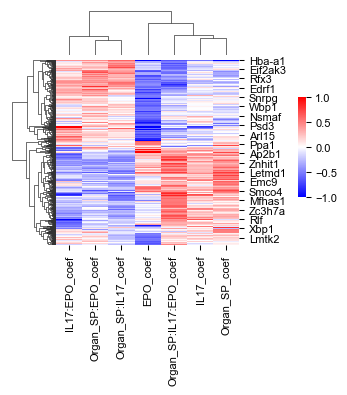

In [4]:
from statsmodels.stats.multitest import multipletests

# Get the p-value columns (corrected)
pval_columns = [col for col in filtered_df.columns if col.endswith('_pval')]

# Apply Benjamini-Hochberg correction (FDR) across the p-values
pval_data = filtered_df[pval_columns]

# Apply multiple hypothesis correction (Benjamini-Hochberg)
corrected_pvals = multipletests(pval_data.values.flatten(), method='fdr_bh')[1]

# Reshape the corrected p-values back into the original shape of the pval_data dataframe
corrected_pval_df = pd.DataFrame(corrected_pvals.reshape(pval_data.shape), 
                                 columns=pval_data.columns, index=pval_data.index)

# Filter significant genes after correction (using a stringent threshold)
significant_genes_corrected = filtered_df[corrected_pval_df.min(axis=1) < 1e-2]

# Now select only the coefficient columns for the significant genes after correction
coefficient_columns = [col for col in filtered_df.columns if '_coef' in col]
significant_genes_coefficients_corrected = significant_genes_corrected[coefficient_columns]

# Set the gene names as the index
significant_genes_coefficients_corrected.index = list(significant_genes_corrected['Gene'])

# Drop the intercept coefficient
significant_genes_coefficients_corrected = significant_genes_coefficients_corrected.drop(columns='Intercept_coef')

# Filter coefficients greater than 0.5 or less than -0.5
filtered_coefficients = significant_genes_coefficients_corrected[
    (significant_genes_coefficients_corrected.abs() > 0.5).any(axis=1)
]

# Plot the clustered heatmap for significant genes after multiple hypothesis correction
ordered = ['IL17_coef', 'EPO_coef','IL17:EPO_coef',
           'Organ_SP_coef', 
           'Organ_SP:EPO_coef', 'Organ_SP:IL17_coef','Organ_SP:IL17:EPO_coef']

sns.clustermap(filtered_coefficients.loc[:,ordered], cmap="bwr", 
               center=0, annot=False, cbar=True, 
               cbar_pos=(1,0.5, 0.025, 0.25),
               vmin=-1, vmax=1, 
               method='complete',
               metric='euclidean',
               #col_cluster=False,
               figsize=(3,4),)

plt.tight_layout()
plt.show()

## performing gene set enrichment on the significant terms

In [5]:
import gseapy as gp
import pandas as pd

# Load the provided dataset
file_path = 'modified_significant_genes_CEP-1.csv'
df = pd.read_csv(file_path)


# Model labels mapping
model_labels = {
    'model_0_lrt_pval_corrected': 'Organ',
    'model_1_lrt_pval_corrected': 'Organ and IL-17 interaction',
    'model_2_lrt_pval_corrected': 'Epo',
    'model_3_lrt_pval_corrected': 'IL-17',
    'model_4_lrt_pval_corrected': 'IL-17 and Epo dual interaction',
    'model_5_lrt_pval_corrected': 'Organ, IL-17, Epo triple interaction',
    'model_6_lrt_pval_corrected': 'Organ and Epo interaction'
}

# Create an empty DataFrame to store the collated results for enrichment analysis
collated_results = pd.DataFrame()

# Loop through each model and perform enrichment analysis
for model_column, model_name in model_labels.items():
    # Filter genes where the model's corrected p-value is less than the threshold
    significant_genes = df[df[model_column] < 0.01]['Gene'].tolist()

    if len(significant_genes) > 0:
        # Perform enrichment analysis using multiple gene sets
        enrichment_results = gp.enrichr(gene_list=significant_genes,
                                        gene_sets=['GO_Biological_Process_2023', 
                                                   'GO_Molecular_Function_2023',
                                                   'GO_Cellular_Component_2023',
                                                   'KEGG_2019_Mouse',
                                                   'WikiPathways_2024_Mouse',
                                                   'Reactome_2022', 
                                                   'MSigDB_Hallmark_2020'],
                                        organism='Mouse',  # Adjust if using other organisms
                                        outdir=None)  # Set outdir to None to avoid file output

        # Extract the results as a DataFrame
        results_df = enrichment_results.res2d

        # Add a column indicating the model name (so we know which model the results are from)
        results_df['model_term'] = model_name

        # Append the results to the collated DataFrame
        collated_results = pd.concat([collated_results, results_df], ignore_index=True)

# Filter the results for Adjusted P-value < 0.05 and remove specific unwanted terms
collated_results = collated_results[collated_results['Adjusted P-value'] < 0.05]
collated_results = collated_results[~collated_results['Term'].str.contains('Myc Targets V2')]

# Save the filtered results to CSV for future use
collated_results.to_csv('enrichment_results_per_model_CEP-2.csv', index=False)

# Preparing data for plotting
collated_results = pd.read_csv('enrichment_results_per_model_CEP-2.csv', index_col=None)
collated_results['Overlap'] = [int(i.split('/')[0]) / int(i.split('/')[1]) for i in collated_results['Overlap']]


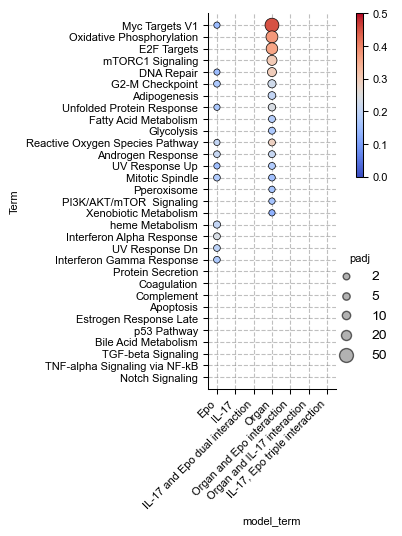

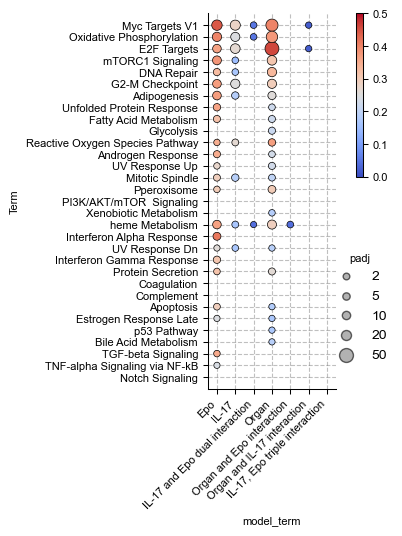

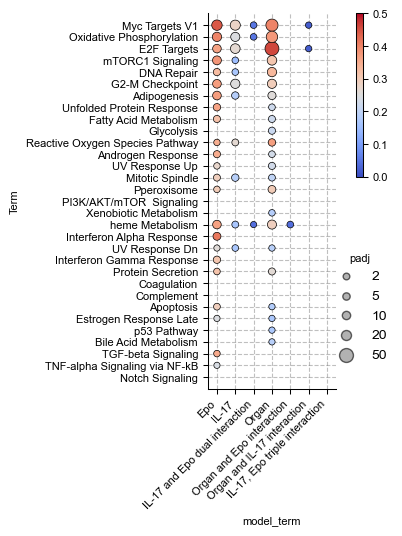

In [6]:
import pandas as pd
import numpy as np

# Step 1: Collect significant terms across all cell states in the order they appear
unified_terms = []

for cellstate in ['EEP', 'CEP-1', 'CEP-2']:
    # Load the precomputed enrichment results
    file_path = f'enrichment_results_per_model_{cellstate}.csv'
    df = pd.read_csv(file_path)

    # Extract significant terms (Adjusted P-value < 0.05)
    significant_terms = df[df['Adjusted P-value'] < 0.05]['Term'].tolist()
    
    # Add to the unified list if not already present (preserve order of first appearance)
    for term in significant_terms:
        if term not in unified_terms:
            unified_terms.append(term)
            
unified_terms.reverse()

# Step 2: Re-run the plotting with unified y-axis across all cell states
for cellstate in ['EEP', 'CEP-1', 'CEP-2']:
    # Load the precomputed enrichment results
    file_path = f'enrichment_results_per_model_{cellstate}.csv'
    df = pd.read_csv(file_path)

    # Filter the results for Adjusted P-value < 0.05
    df_filtered = df[df['Adjusted P-value'] < 0.05]

    # Ensure 'Overlap' column is calculated
    df_filtered['Overlap'] = [int(i.split('/')[0]) / int(i.split('/')[1]) for i in df_filtered['Overlap']]

    # Ensure 'model_term' is a categorical variable with a custom order
    order = ['Epo', 'IL-17', 'IL-17 and Epo dual interaction', 'Organ', 
             'Organ and Epo interaction', 'Organ and IL-17 interaction', 
             'IL-17, Epo triple interaction']
    df_filtered['model_term'] = pd.Categorical(df_filtered['model_term'], categories=order, ordered=True)
    df_filtered['Term'] = pd.Categorical(df_filtered['Term'], categories=unified_terms, ordered=True)

    # Ensure the y-axis has the unified terms across all cell states
    df_filtered = df_filtered[df_filtered['Term'].isin(unified_terms)]

    # Prepare the data for plotting
    df_plot = df_filtered.copy()
    df_plot['padj'] = -np.log10(df_plot['Adjusted P-value'])

    # Plotting code (same as before)
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    import matplotlib.gridspec as gridspec
    import numpy as np

    color_norm = Normalize(vmin=0, vmax=0.5)  # Overlap ranges between 0 and 1
    size_norm = Normalize(vmin=0, vmax=50)  # padj ranges between 0 and 50
    cmap = sns.color_palette('coolwarm', as_cmap=True)

    fig = plt.figure(figsize=(2, 1 + (len(unified_terms) / 8)))
    gs = gridspec.GridSpec(nrows=2, ncols=2, 
                           width_ratios=[1, 0.05], height_ratios=[1, 1], 
                           hspace=0.3, wspace=0.3)

    ax_main = fig.add_subplot(gs[:, 0])  # Main scatter plot

    scatter = sns.scatterplot(
        data=df_plot,
        x='model_term',
        y='Term',
        hue='Overlap',
        size='padj',
        sizes=(20, 100),
        palette=cmap,
        edgecolor='k',
        linewidth=0.5,
        hue_norm=(0, 0.5),
        zorder=10,
        ax=ax_main,
        legend=False
    )

    ax_main.grid(True, which='both', axis='both', linestyle='--', color='gray', alpha=0.5, zorder=-3)
    ax_main.set_xticks(range(7))  # Set fixed positions for all terms in the order
    ax_main.set_xticklabels(order, rotation=45, ha='right')
    ax_main.set_xlim([-0.5, 6.5])
    ax_main.set_ylim([-1, len(unified_terms)])  # Set y-limits to span the unified terms
    ax_main.set_yticks(range(len(unified_terms)))  # Set the y-ticks to the number of terms
    ax_main.set_yticklabels(unified_terms)  # Use the unified terms as the y-tick labels

    cax_color = fig.add_subplot(gs[0, 1])  # Top-right subplot
    sm = ScalarMappable(cmap=cmap, norm=color_norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cax_color)

    cax_size = fig.add_subplot(gs[1, 1])  # Bottom-right subplot
    padj_legend_values = [2, 5, 10, 20, 50]
    size_legend_sizes = size_norm(padj_legend_values) * (100 - 20) + 20

    for size in size_legend_sizes:
        cax_size.scatter([], [], s=size, color='gray', edgecolor='k', alpha=0.6)
    cax_size.axis('off')

    handles = [plt.scatter([], [], s=size, color='gray', edgecolor='k', alpha=0.6) for size in size_legend_sizes]
    labels = padj_legend_values
    legend = cax_size.legend(handles, labels, title='padj', loc='center', labelspacing=0.5, scatterpoints=1, frameon=False)

    #plt.tight_layout()

    # Save the plot
    plt.savefig(figure_path + f'scatterplot_enrichment_analysis_ordered_{cellstate}.pdf', dpi=300, bbox_inches='tight')

    plt.show()